In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sgcc import *

In [2]:
# First, set the inputs to the model: a set of spatial frequency values (in cycles per degree c/d)

X = tf.convert_to_tensor([0.02,0.04,0.08,0.1,0.12,0.16,0.2,0.24,0.28,0.32], dtype = tf.float32)

In [3]:
## We will be fitting the model to the first two PCs of the PCA transformed V1 data.

v1_xs_file = os.path.join("project_datafiles", "v1_ori_phase_condition_pcascores_wcomp.pkl")
v1_scores = pd.read_pickle(v1_xs_file)
v1_scores_condition_averaged = np.array([np.array(x) for x in v1_scores.scores.values]).mean(0)
Y_true = v1_scores_condition_averaged[:2,:,:].transpose(0,2,1)

In [4]:
## Model initialization

# set some bounds for the model parameters
param_bounds = {
    "fts": [20, 200],
    "t": [40, 100],
    "ats": [-3, 0],
    "a": [0.1, 4],
    "d": [10, 40],
    "inh_d": [0, 40],
    "inh_w": [0, 3],
}

# initialize the model
model = SGCCircuit(param_bounds)

# initialize some random starting parameters
model.initialize_random_parameters(
    n_lgn=3, # number of dLGN units
    n_v1=2, # number of V1 units
    n_sample=100 # number of exploration samples
)

In [5]:
## initialize an instance of the optimizer

optimizer = Optimize(
    model, 
    epochs=2000, # model starts fully converging around 5000 epochs, kept it low here for demonstration. 
    loss_threshold=0.11 # freeze optimization for samples that reach this loss value
)


Optimizer initialized with <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001FCFDAAF6D0>


In [6]:
## fit the model

t0 = time.time()
loss_decay = optimizer.fit(X, Y_true)
t1 = time.time()
print(f"Ran {optimizer.epochs} optimization epochs in {round(t1-t0, 2)} sec. Average = {round((t1-t0)/(optimizer.epochs), 2)} sec/epoch.")

Training step = 0, N_exploration_samples = 100,
min_loss = 0.5442950129508972
med_loss = 3.784975528717041
max_loss = 15.483085632324219

Training step = 100, N_exploration_samples = 100,
min_loss = 0.4029533863067627
med_loss = 2.894190788269043
max_loss = 12.893854141235352

Training step = 200, N_exploration_samples = 100,
min_loss = 0.31691619753837585
med_loss = 2.1808385848999023
max_loss = 10.641701698303223

Training step = 300, N_exploration_samples = 100,
min_loss = 0.2552078068256378
med_loss = 1.6838388442993164
max_loss = 8.718086242675781

Training step = 400, N_exploration_samples = 100,
min_loss = 0.21177983283996582
med_loss = 1.3702057600021362
max_loss = 7.1190314292907715

Training step = 500, N_exploration_samples = 100,
min_loss = 0.18347236514091492
med_loss = 1.1200840473175049
max_loss = 5.821176528930664

Training step = 600, N_exploration_samples = 100,
min_loss = 0.1648731380701065
med_loss = 0.9328176379203796
max_loss = 4.785987377166748

Training step = 7

Text(0, 0.5, 'Loss (MSE)')

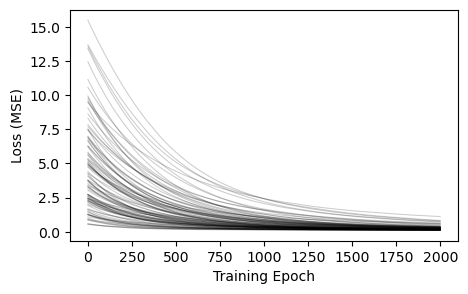

In [7]:
fig, ax = plt.subplots(figsize = (5,3))
plt.plot(loss_decay, alpha = 0.2, color = 'black', linewidth = 0.75)

ax.set_xlabel("Training Epoch")
ax.set_ylabel("Loss (MSE)")

In [8]:
## The optimizer automatically tracks and saves the following as variables in the current session:

optimizer.outputs.keys()

dict_keys(['converged_samples', 'param_history', 'scaled_param_history', 'gradient_history', 'loss_decay', 'final_epoch_params'])

In [9]:
## inspect the parameters after optimization
param_history = optimizer.outputs['param_history']

Text(0.525, 0.95, 'Distribution of V1 parameters post-optimization')

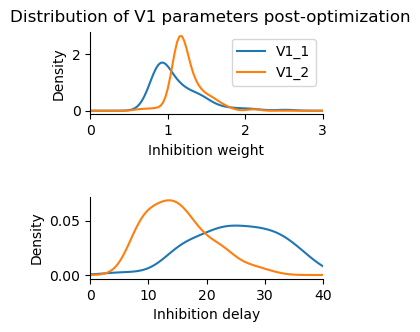

In [10]:
## plot the V1 parameter distributions

fig, ax = plt.subplots(2,1, figsize = (3,2*(8/5)))

for i in range(2):
    i_ = np.abs(i-1)
    for u in range(2):
        x = np.linspace(
            list(param_bounds.values())[-1-i][0],
            list(param_bounds.values())[-1-i][1],
            100
        )
        data = param_history['V1_params'][:,-1,u,0,i_,0,0]
        kde = gaussian_kde(data)
        y = kde(x)

        ax[i].plot(x,y, label = f'V1_{u+1}')
        ax[i].set_xlim(
            list(param_bounds.values())[-1-i][0],
            list(param_bounds.values())[-1-i][1]
        )
        ax[i].set_ylabel("Density")
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

ax[0].set_xlabel('Inhibition weight')
ax[1].set_xlabel('Inhibition delay')
ax[0].legend()
fig.subplots_adjust(hspace=1)
plt.suptitle("Distribution of V1 parameters post-optimization", x = 0.525, y = 0.95)